# `ResNet` 

## 残差块
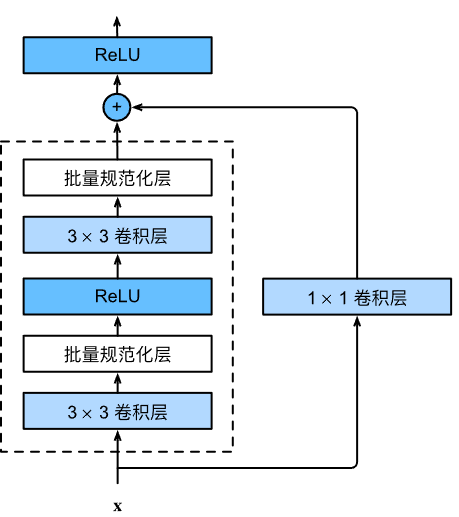

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [5]:
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_11conv=False,strides=1):
        super().__init__()
        # 先是两个3*3卷积层
        self.conv1 = nn.Conv2d(input_channels,num_channels,
                               kernel_size=3,padding=1,stride=strides)
        self.conv2 = nn.Conv2d(num_channels,num_channels,
                               kernel_size=3,padding=1)
        if use_11conv:
            self.conv3 = nn.Conv2d(input_channels,num_channels,
                                  kernel_size=1,stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self,X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        
        # 残差连接
        Y += X
        return F.relu(Y)

In [6]:
blk = Residual(3,3)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

尝试增加输出通道数，同时减半高度和宽度

In [7]:
blk = Residual(3,6,use_11conv=True,strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## `ResNet` 模型
- 输出通道数为 `64` ，步幅为 `2` 的 $7\times 7$ 卷积层
- 批量规范化层
- 步幅为 `2` 的 $3\times 3$ 最大汇聚层
- `4` 个由残差块组成的模块。第一个模块的输入输出通道数相同，并且因为已经经过步幅为 `2` 的最大汇聚层，因此无需减小高度和宽度，之后的每一个模块输出通道数翻倍，高度和宽度减半
- 全局平均汇聚层
- 全连接层

In [8]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                  nn.BatchNorm2d(64),nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [19]:
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels,num_channels,
                                use_11conv=True,strides=2))
        else:
            blk.append(Residual(num_channels,num_channels))
        
    return blk

在 `ResNet` 中加入所有残差块，每个模块使用 `2` 个残差块

In [20]:
b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3 = nn.Sequential(*resnet_block(64,128,2))
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))

最后加入全局平均汇聚层和全连接层输出

In [25]:
net = nn.Sequential(b1,b2,b3,b4,b5,
                   nn.AdaptiveAvgPool2d((1,1)), # 输出尺寸是(1,1)，而非窗口形状
                   nn.Flatten(),nn.Linear(512,10))

查看每层输出形状

In [26]:
X = torch.rand(size=(1,1,224,224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,"output shape:\t",X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 训练模型


loss 0.012, train acc 0.997, test acc 0.921
214.0 examples/sec on cpu


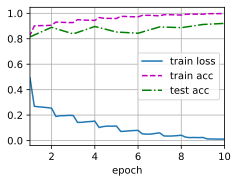

In [27]:
lr,num_epochs,batch_size = 0.05,10,256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())